# Reproduce PEFT(Parameter-Efficient Fine-Tuning) on Pre-trained Model with Batch Correction
In this tutorial, we demonstrate how to reproduce a PEFT (Parameter-Efficient Fine-Tuning) pre-trained model on a specific dataset for the batch correction task. This tutorial serves as a practical example. There are two steps that need to be executed. 

## Step 1: Modify the parameters

### There are four key settings that the reader needs to modify. The available options are listed below:
***dataset_name*** : covid_subsampled / PBMC_10K / Perirhinal Cortex   
***load_model***: {checkpoint_path}/batch_correction  
***data_path***: {data_path}/batch_correction  
***use_peft***: True / False. If you want to evaluate pefted model, you should use True, otherwise you should use False  
***peft_type***: Encoder_adapter/ Token_adapter / Prefix / LoRA / finetune.  


In [1]:
key_parameters = dict(
    dataset_name="PBMC_10K",  # Dataset name
    load_model="../save/batch_correction",  # Path to peft model
    data_path="../data/batch_correction",# Path to dataset
    use_peft=True,  # if use_peft is False, the peft_type must be setted to finetune
    peft_type="Encoder_adapter"  # Encoder_adapter/ Token_adapter / Prefix / LoRA / finetune
)

## Step 2:  Start the validation

In [2]:
import json
import os
from pathlib import Path
import sys
import traceback
from typing import List, Tuple, Dict, Union, Optional
import warnings
import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
from scipy.sparse import issparse
from torch import nn
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import argparse

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.model.model_prompt import TransformerModel, AdversarialDiscriminator
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, eval_scib_metrics, load_pretrained, eval_scib_metrics_all

Global seed set to 0
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/users/PCON0022/coffee19850519/ondemand/scPEFT_reproduction/publication/../scgpt/model/model_prompt.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [3]:
sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [4]:
hyperparameter_defaults = dict(
    seed=42,
    GEPC=True,  # Gene expression modelling for cell objective
    ecs_thres=0.8,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,  # DAR objective weight for batch correction
    mask_ratio=0.4,  # Default mask ratio
    epochs=40,  # Default number of epochs for fine-tuning
    n_bins=51,  # Default number of bins for value binning in data pre-processing
    lr=1e-4,  # Default learning rate for fine-tuning
    batch_size=20,  # Default batch size for fine-tuning
    layer_size=128,
    nlayers=4,
    nhead=4,  # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2,  # Default dropout rate during model fine-tuning
    schedule_ratio=0.9,  # Default rate for learning rate decay
    save_eval_interval=5,  # Default model evaluation interval
    log_interval=100,  # Default log interval
    fast_transformer=False,  # Default setting
    pre_norm=False,  # Default setting
    amp=True,  # # Default setting: Automatic Mixed Precision
    num_tokens=2000,
    n_layers_conf=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # token
    mlp_adapter_conf=[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    space_adapter_conf=[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
    no_tracemalloc=False,
)

peft_prompt_relationship = {
    "Encoder_adapter": "encoder-prompt",
    "Token_adapter": "head-prompt",
    "Prefix": "prefix-prompt",
    "LoRA": "LoRA",
    "finetune": "finetune"
}

hyperparameter_defaults.update(key_parameters)
config = argparse.Namespace(**hyperparameter_defaults)

config.use_prompt = config.use_peft
config.prompt_type = peft_prompt_relationship[config.peft_type]

set_seed(config.seed)


In [5]:
# settings for input and preprocessing
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
mask_ratio = config.mask_ratio
mask_value = -1
pad_value = -2
n_input_bins = config.n_bins

data_path = config.data_path
use_prompt = config.use_prompt
prompt_type = config.prompt_type
num_tokens = config.num_tokens
n_layers_conf = config.n_layers_conf
mlp_adapter_conf = config.mlp_adapter_conf
space_adapter_conf = config.space_adapter_conf

n_hvg = 1200  # number of highly variable genes
max_seq_len = n_hvg + 1
per_seq_batch_sample = True
DSBN = True  # Domain-spec batchnorm
explicit_zero_prob = True  # whether explicit bernoulli for zeros

In [6]:
dataset_name = config.dataset_name
data_dir = Path(config.data_path)
if dataset_name == "PBMC_10K":
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")  # 11990 × 3346
    ori_batch_col = "batch"
    adata.obs["celltype"] = adata.obs["str_labels"].astype("category")
    adata.var = adata.var.set_index("gene_symbols")
    data_is_raw = True

elif dataset_name == "covid_subsampled":
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")

    ori_batch_col = "str_batch"
    data_is_raw = True
    n_hvg = None

elif dataset_name == "Perirhinal Cortex":
    adata = sc.read(data_dir / f"{dataset_name}.h5ad")
    ori_batch_col = "sample_id"
    adata.obs["celltype"] = adata.obs["cell_type"].astype("category")
    adata.var = adata.var.set_index("Gene")
    data_is_raw = True

In [7]:
# make the batch category column
adata.obs["str_batch"] = adata.obs[ori_batch_col].astype(str)
batch_id_labels = adata.obs["str_batch"].astype("category").cat.codes.values
adata.obs["batch_id"] = batch_id_labels
adata.var["gene_name"] = adata.var.index.tolist()

In [8]:
if config.load_model is not None:
    model_dir = Path(config.load_model, config.dataset_name, config.peft_type)
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    adata = adata[:, adata.var["id_in_vocab"] >= 0]

    # model
    with open(model_config_file, "r") as f:
        model_configs = json.load(f)

    embsize = model_configs["embsize"]
    nhead = model_configs["nheads"]
    d_hid = model_configs["d_hid"]
    nlayers = model_configs["nlayers"]
    n_layers_cls = model_configs["n_layers_cls"]
else:
    embsize = config.layer_size
    nhead = config.nhead
    nlayers = config.nlayers
    d_hid = config.layer_size


In [10]:
# set up the preprocessor, use the args to config the workflow
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="str_batch" if dataset_name != "heart_cell" else None)

if per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

input_layer_key = "X_binned"
all_counts = (
    adata.layers[input_layer_key].A
    if issparse(adata.layers[input_layer_key])
    else adata.layers[input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

if config.load_model is None:
    vocab = Vocab(
        VocabPybind(genes + special_tokens, None)
    )  # bidirectional lookup [gene <-> int]
vocab.set_default_index(vocab["<pad>"])
gene_ids = np.array(vocab(genes), dtype=int)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Log1p transforming ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=pad_token,
    pad_value=pad_value,
    do_mvc=config.GEPC,
    do_dab=True,
    use_batch_labels=True,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=DSBN,
    n_input_bins=n_input_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    use_prompt=use_prompt,
    num_tokens=num_tokens,
    prompt_type=prompt_type,
    n_layers_conf=n_layers_conf,
    mlp_adapter_conf=mlp_adapter_conf,
    space_adapter_conf=space_adapter_conf,
)
if config.load_model is not None:
    try:
        model.load_state_dict(torch.load(model_file, map_location=device))
        print(f"Loading all model params from {model_file}")
    except Exception as e:
        traceback.print_exc()
        print(e)

model.to(device)

Use domain specific batchnorm with affine=False
Loading all model params from ../save/batch_correction/PBMC_10K/Encoder_adapter/best_model.pt


TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(60697, 512, padding_idx=60694)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(2, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (dsbn): DomainSpecificBatchNorm1d(
    (bns): ModuleList(
      (0-1): 2 x BatchNorm1d(512, eps=6.1e-05, momentum=0.1, affine=False, track_running_stats=True)
    )
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (prompt_dropout): Dropout(p=0, inplace=False)
        (prompt_proj):

In [12]:
def eval_testdata(
        model: nn.Module,
        adata_t: AnnData,
        include_types: List[str] = ["cls"],
) -> Optional[Dict]:
    """evaluate the model on test dataset of adata_t"""
    model.eval()

    # copy adata_t to avoid reuse previously computed results stored in adata_t
    adata_t = adata_t.copy()

    all_counts = (
        adata_t.layers[input_layer_key].A
        if issparse(adata_t.layers[input_layer_key])
        else adata_t.layers[input_layer_key]
    )

    celltypes_labels = adata_t.obs["celltype"].tolist()
    celltypes_labels = np.array(celltypes_labels)

    batch_ids = adata_t.obs["batch_id"].tolist()
    batch_ids = np.array(batch_ids)

    # Evaluate cls cell embeddings
    if "cls" in include_types:
        print("Evaluating cls cell embeddings")
        tokenized_all = tokenize_and_pad_batch(
            all_counts,
            gene_ids,
            max_len=max_seq_len,
            vocab=vocab,
            pad_token=pad_token,
            pad_value=pad_value,
            append_cls=True,  # append <cls> token at the beginning
            include_zero_gene=True,
        )
        all_gene_ids, all_values = tokenized_all["genes"], tokenized_all["values"]
        src_key_padding_mask = all_gene_ids.eq(vocab[pad_token])
        if use_prompt and prompt_type == 'prefix_prompt':
            bool_tensor = torch.empty((all_gene_ids.shape[0], num_tokens), dtype=torch.bool).to(device)
            bool_tensor.fill_(src_key_padding_mask[0][0].item()).to(device)

        with torch.no_grad(), torch.cuda.amp.autocast(enabled=config.amp):
            cell_embeddings = model.encode_batch(
                all_gene_ids,
                all_values.float(),
                src_key_padding_mask=src_key_padding_mask,
                batch_size=config.batch_size,
                batch_labels=torch.from_numpy(batch_ids).long() if DSBN else None,
                time_step=0,
                return_np=True,
            )
        cell_embeddings = cell_embeddings / np.linalg.norm(
            cell_embeddings, axis=1, keepdims=True
        )

        adata_t.obsm["X_scGPT"] = cell_embeddings

        results = {}
        try:
            results = eval_scib_metrics(adata_t)
        except Exception as e:
            traceback.print_exc()
            print(e)

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["str_batch"],
            title=[f"batch, avg_batch = {results.get('avg_batch', 0.0):.4f}"],
            frameon=False,
            show=True,
        )

        sc.pp.neighbors(adata_t, use_rep="X_scGPT")
        sc.tl.umap(adata_t, min_dist=0.3)
        fig = sc.pl.umap(
            adata_t,
            color=["celltype"],
            title=[
                f"celltype, avg_bio = {results.get('avg_bio', 0.0):.4f}",
            ],
            frameon=False,
            show=True
        )

    if len(include_types) == 1:
        return results

Evaluating cls cell embeddings


100%|██████████| 600/600 [01:22<00:00,  7.24it/s]


NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.827300
ARI_cluster/label          0.862938
ASW_label                  0.681752
ASW_label/batch            0.949130
PCR_batch                  0.607883
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.964310
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     NaN
trajectory                      NaN
scGPT - INFO - Biological Conservation Metrics: 
ASW (cell-type): 0.6818, graph cLISI: nan, isolated label silhouette: nan, 
Batch Effect Removal Metrics: 
PCR_batch: 0.6079, ASW (batch): 0.9491, graph connectivity: 0.9643, graph iLISI: nan
scGPT - INFO - avg bio (cell-type): 0.7907 

scGPT - INFO - avg batch (batch): 0.9567 

scGPT - INFO - overall(0.6*avg bio + 0.4*av

/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/users/PCON0022/coffee19850519/.conda/envs/scGPT/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or 

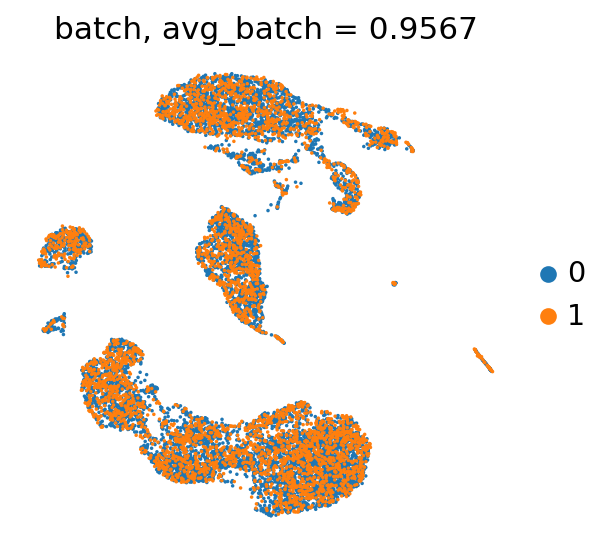

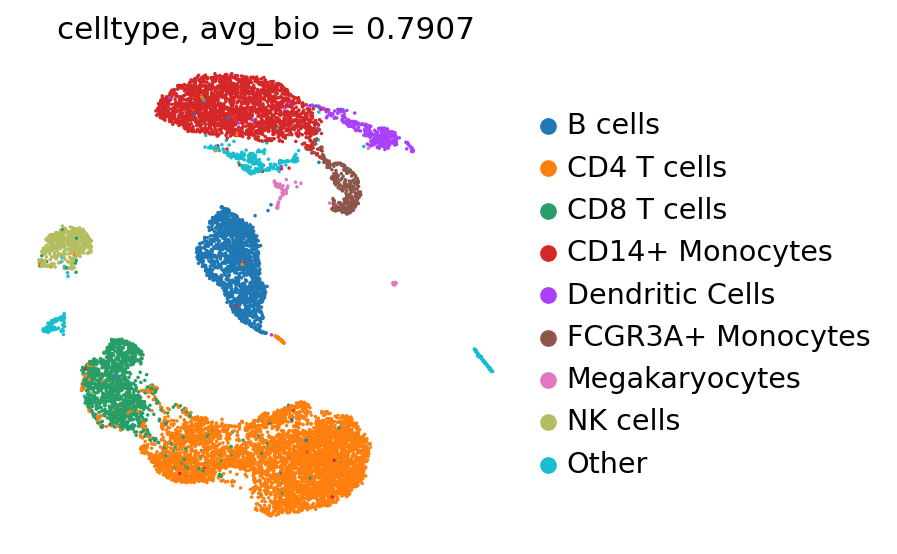

In [13]:
# eval on testdata
results = eval_testdata(
    model,
    adata_t=adata_sorted if per_seq_batch_sample else adata,
    include_types=["cls"],
)

In [20]:
for k,v in results.items():
    print(f"{k} -> {v}")

NMI_cluster/label -> 0.827300393743433
ARI_cluster/label -> 0.8629376173591913
ASW_label -> 0.6817516386508942
ASW_label/batch -> 0.9491304217104103
PCR_batch -> 0.6078828288302158
graph_conn -> 0.9643103442899221
avg_bio -> 0.7906632165845062
avg_batch -> 0.9567203830001663


In [24]:
print(f"Overall is {results['avg_bio'] * 0.6 + results['avg_batch'] * 0.4:.4f}")

Overall is 0.8571
